## Micah Goldade {-}

## Abstract {-}

*This analysis compares the terrain along three major long-distance thru-hike trails in the United States to identify areas of geological complexity. The terrain is characterized based on Digital Elevation Model (DEM) data derived from the Shuttle Radar Topography Mission (SRTM) dataset. This analysis attempts to derive an appropriate frequency signature for sections of the trail using Fast Fourier Transform (FFT) on elevation profiles filtered by the Continuous Wavelet Transform (CWT). These signatures are then analyzed using Singular Value Decomposition (SVD) to identify the relative complexity of the terrain on these trails.*

# Introduction and Overview

The United States is famous for its large variety of geographic regions, particularly those protected by organizations including the National Parks System. One of the more extreme and romanticized methods to enjoy these preserved areas is to plan a thru-hike of one of the three major long-distance hiking trails - the Pacific Crest Trail (PCT), the Continental Divide Trail (CDT), or the Appalachian Trail (AT).

Attempting a thru-hike of any one of these trails can be a years long effort for planning and execution. As of 2018 less than 400 hikers have completed all three and been awarded the [Triple Crown of Hiking](https://en.wikipedia.org/wiki/Triple_Crown_of_Hiking).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from osgeo import gdal
from pathlib import Path
from bokeh.plotting import figure, output_file, output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.tile_providers import Vendors, get_provider
from bokeh.io import export_png
from scipy import linalg
import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
# logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import project

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load, unzip, and make directories for trial maps for use in plotting
Path("./data/maps/").mkdir(parents=True, exist_ok=True)
Path("./data/trail-shapefiles/").mkdir(parents=True, exist_ok=True)

# Unzip and prepare shapefile directories
!unzip -o -q ./data/imported/stelprdb5332131.zip -d ./data/trail-shapefiles/pct/
!unzip -o -q ./data/imported/CDTbyState20161128.zip -d ./data/trail-shapefiles/cdt/
!unzip -o -q ./data/imported/AT_Centerline_12-23-2014.zip -d ./data/trail-shapefiles/at/

In [3]:
spacing=20000
# spacing=5000

pct = project.Trail()
pct.process_trail_from_shapefile('./data/trail-shapefiles/pct/', subsample_rate=100, spacing=spacing)

cdt = project.Trail()
cdt.process_trail_from_shapefile('./data/trail-shapefiles/cdt/', subsample_rate=1000, spacing=spacing)

at = project.Trail()
at.process_trail_from_shapefile('./data/trail-shapefiles/at/', subsample_rate=100, spacing=spacing)

In [4]:
output_file("./data/maps/three-trail-map.html")
output_notebook()

tile_provider = get_provider(Vendors.STAMEN_TERRAIN)

p = figure(title='Routes of long-distance trails',
           x_range=(-13e6, -8e6),
           y_range=(2.5e6, 7e6),
           sizing_mode='stretch_both',
           x_axis_type="mercator",
           y_axis_type="mercator"
          ) 
p.add_tile(tile_provider)

p.line(x=pct.coordinates_sampled[0], y=pct.coordinates_sampled[1], line_width=2, color='blue', legend_label='Pacific Crest Trail (PCT)')
p.line(x=cdt.coordinates_sampled[0], y=cdt.coordinates_sampled[1], line_width=2, color='red', legend_label='Continental Divide Trail (CDT)')
p.line(x=at.coordinates_sampled[0], y=at.coordinates_sampled[1], line_width=2, color='orange', legend_label='Appalachian Trail (AT)')

# p.circle(x=pct.coordinates[0], y=pct.coordinates[1], size=3, color='blue', legend_label='Pacific Crest Trail (PCT)')
# p.circle(x=cdt.coordinates[0], y=cdt.coordinates[1], size=3, color='red', legend_label='Continental Divide Trail (CDT)')
# p.circle(x=at.coordinates[0], y=at.coordinates[1], size=3, color='orange', legend_label='Appalachian Trail (AT)')


# p.quad(pct.mapping_bounding_boxes[0], pct.mapping_bounding_boxes[1], pct.mapping_bounding_boxes[2], pct.mapping_bounding_boxes[3], color='blue', alpha=0.1)
# p.quad(cdt.mapping_bounding_boxes[0], cdt.mapping_bounding_boxes[1], cdt.mapping_bounding_boxes[2], cdt.mapping_bounding_boxes[3], color='red', alpha=0.1)
# p.quad(at.mapping_bounding_boxes[0], at.mapping_bounding_boxes[1], at.mapping_bounding_boxes[2], at.mapping_bounding_boxes[3], color='orange', alpha=0.1)
export_png(p, filename="./data/images/three-trail-map.png")

show(p)


Loading BokehJS ...

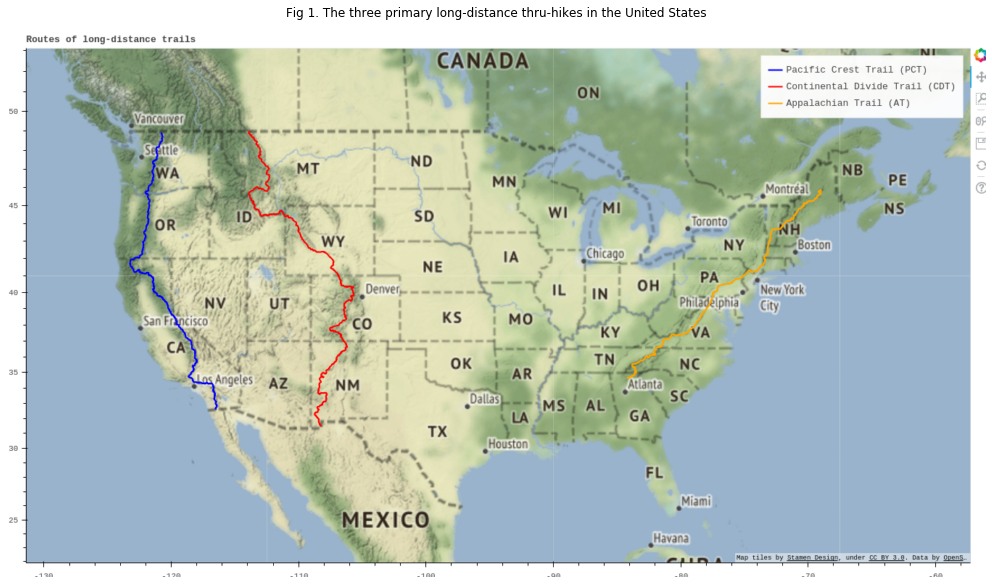

In [5]:
# Image added for report generation
img1 = mpimg.imread("./data/images/three-trail-map.png")
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,8))
ax.imshow(img1, interpolation="bilinear")
ax.axis('off')
fig.suptitle('Fig 1. The three primary long-distance thru-hikes in the United States')
fig.show()



Since seeing all of this geography in person is out of reach for most of us, I wanted to perform an analysis on the terrain along these trails to try to **1)** determine a frequency signature that helped describe the topology on a given point along the trails, **2)** determine if any portions of the trails have a particularly unique terrain frequency signature, and **3)** determine which trail has the most complex terrain profile and is best (*just kidding, I'm sure they are all great*).

# Theoretical Background


The largest challenge for this project was researching, understanding, locating, and transforming geographic terrain datasets suitable for this analysis.

At first, it seems like the process should be relatively simple. Large mapping projects such as Google Maps and OpenStreetMap have synthesized large collections of terrain data, showing it is possible. Furthermore, much of the data required for this analysis was procured by the United States Geographical Survey (USGS), and therefore should be free and easy to download and use. However, this over-simplification misrepresents how complex the process of generating terrain data to generate Geographic Information System (GIS) data can be. As a naive engineer with no previous GIS experience, I quickly learned just how complicated the process can be, especially when needing to work with minimally processed source data. The following are the main concepts I needed to work through to complete the analysis. 

## Digital Elevation Models

The primary terrain of interest for this analysis is the elevation profile. Attempting to use data for other terrain features, such as vegetation, would be both difficult to find, and also difficult for comparison since not all areas have vegetation. However, all regions will have an elevation profile. 

Elevation data is typically processed as a Digital Elevation Model (DEM). Although there are vector based DEMs, the most common DEM type appears to be as a raster, with a 2 dimensional matrix of equally spaced x-y coordinates containing elevation. This DEM raster data format is well-suited for this analysis, and will be the primary data format.

An important consideration of DEM raster data is what dataset it was based on and how it was processed, since there is an large variation in both quality and availability of elevation data.

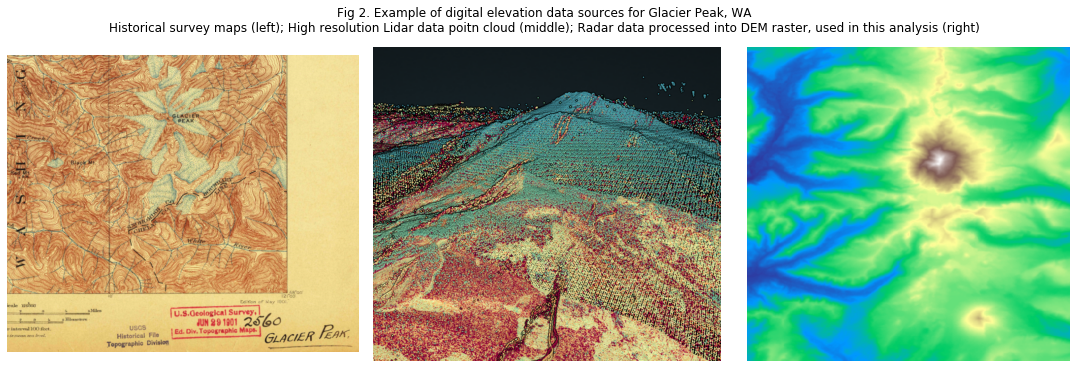

In [6]:
img1 = mpimg.imread('./data/images/usgs-historic-glacier.PNG')
img2 = mpimg.imread('./data/images/usgs-lidar-glacier.PNG')
img3 = mpimg.imread('./data/images/usgs-radar-glacier.PNG')
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15,5))
axs[0].imshow(img1, interpolation="bilinear")
axs[1].imshow(img2, interpolation="bilinear")
axs[2].imshow(img3, interpolation="bilinear")
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
fig.suptitle('Fig 2. Example of digital elevation data sources for Glacier Peak, WA\nHistorical survey maps (left); High resolution Lidar data poitn cloud (middle); Radar data processed into DEM raster, used in this analysis (right)')
fig.show()

### Manual land surveying

The original data source for DEM maps came from manual land surveys. The DEM datasets relying on this data are based on historical topographic maps. Although they have been a great resource, these datasets are being enhanced to higher resolutions using standardized data collection methods noted below.

### Photogrammetry

Photogrammetry finds correlations in photographed images to build a DEM dataset. This process can add accuracy to land surveying methods. Some of the limitations of this dataset include attempting to create a "bare-earth" model without vegetation, since areas like thick forests are hard to process.


### Lidar

Lidar, which illuminates a target with light and measures reflection, can create an even more accurate DEM model, especially in areas with vegetation since the illumination methods can penetrate some foliage. 

Lidar datasets are often the highest resolution datasets available, and this method can also create some incredible looking 3D point-cloud datasets. These point cloud sets are then processed to generate highly DEM raster dataset for analysis.

Unfortunately these datasets are less reliable for this type of analysis, since the availability of consistent data is not yet there. Some regions have great coverage of Lidar data, but most areas of the US, and most of the trail systems, do not have any Lidar data available.

### Radar

Most useful dataset for this type of analysis is obtained by radar missions, such as the [Shuttle Radar Topography Mission (SRTM)](https://www2.jpl.nasa.gov/srtm/), which used radar to obtain consistent elevation data on a near global scale. Although the resolution is significantly lower for radar than that of some Lidar datasets (e.g. 30 meter resolution vs 3 meter resolution), the consistency and scope of the STRM dataset made it by far the most useful type of dataset considered. The lower resolution is also not a concern, since we will focus the analysis on larger features anyways due to computational resource limitations.

> Note: Although Lidar and Radar datasets are often available with "raw" source of x-y-z coordinates, the most useful format to work with in this analysis is a DEM raster file. These DEM files have been filtered and processed, potentially enhanced by information from additional data sources, and this analysis assumes the USGS will do a much better job of filtering the raw data than I ever could. 

## Data Sources

The primary source of elevation datasets for the United States is the USGS, which obtains, process and maintains the majority of the data. They are a great resource to find and review specific dataset, but their web tools can be a challenge to work with in obtaining consistent data.  

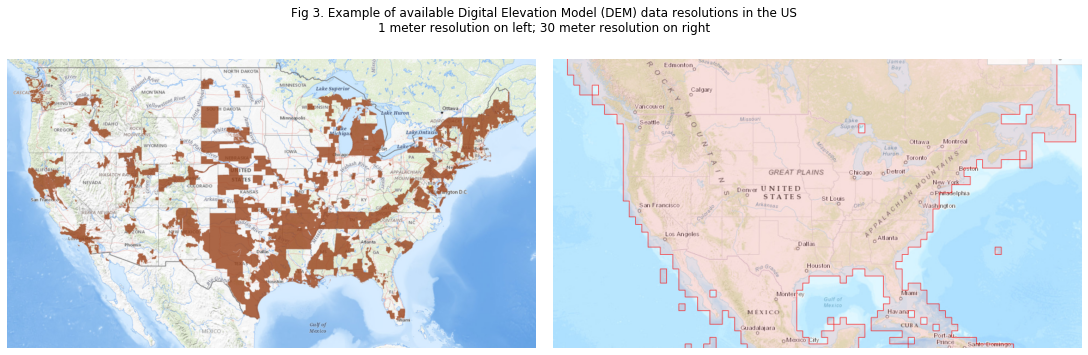

In [7]:
# plot national maps, opentopography
img1 = mpimg.imread('./data/images/usgs-1m-res-map.PNG')
img2 = mpimg.imread('./data/images/ot-30m-res-map.PNG')
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5))
axs[0].imshow(img1, interpolation="bilinear")
axs[1].imshow(img2, interpolation="bilinear")

axs[0].axis('off')
axs[1].axis('off')
fig.suptitle('Fig 3. Example of available Digital Elevation Model (DEM) data resolutions in the US\n1 meter resolution on left; 30 meter resolution on right')
fig.show()

### The National Map

[The National Map](https://viewer.nationalmap.gov/advanced-viewer/) is an awesome project intended to combine a large amount of mapping information into one [data access portal](https://viewer.nationalmap.gov/basic/). It is useful for exploring which data is available beyond just elevation data. It is also simple to download individual datasets, including raw Lidar data. However, it is limited in the ability to stitch together DEM files.


### OpenTopography

Fortunately, the [OpenTopology](https://opentopography.org/) organization has setup a great method to pull elevation datasets from various sources, including STRM. In particular, they have an RESTful API leveraged in the analysis to pull consistent STRM data stitched into the sizes needed. This saves an extremely large amount of tedious data transformation and processing.

> Note: OpenTopography also has access to higher resolution global datasets. However, it appears these higher resolution sets change resolution depending on what is available within a given region. Therefore, for a consistent comparison, we use the STRM data directly. 



## Geographic Projections and Coordinate Reference Systems

I could boil the majority of the complexities with this analysis to one issue - the earth is unfortunately not flat. Furthermore, it isn't even a very good sphere. This complexity is abstracted away when mapping products are produced for specific use cases. However, when combining datasets from various sources using an appropriate coordinate transformation for the datasets is of the utmost importance. 

There are thousands of Coordinate Reference Systems (CRS) maintained in the European Petroleum Survey Group (EPSG) Geodetic Parameter Dataset registry, now maintained by the International Assosication of Oil and Gas Producers (IOGP) Geomatics Committee. The datasets available for trail maps and topography in general may be provided in any one of the various coordinate systems. It is therefore important to transform the data to the coordinate systems most appropriate for the analysis.

We will focus on two coordinate systems specificed in the EPSG - the World Geodetic System and the Web Mercator Projection.

### World Geodetic System

The [World Geodetic System (WGS)](https://en.wikipedia.org/wiki/World_Geodetic_System) is used when accuracy is required. The coordinate includes an approximation of the Earth's shape in an Elliptic coordinate system (these shape approximations are known as [geodetic reference datums](https://en.wikipedia.org/wiki/Geodetic_datum)). Although more accurate geodetic datums exist based on more complex shapes, the WGS has become the primary standard for global accuracy, is accurate up to a couple meters, and used for satellite navigation including GPS.

The WGS data format is the standard used for the SRTM dataset, and is used as an input to the OpenTopology API. Note that when calculating distances in WGS format, the conversion approximation of 1 degree = 111.320 km will be used. This allow the convenience of a consistent shape of the DEM files with the minor sacrifice of a slightly less exact distance measurement.  

> Note: WGS is specified as **EPSG:4326**.

### Web Mercator Projection

The generally population views and works with data on flat maps, particularly through using web mapping applications such as Google Maps and OpenStreetMaps. These maps use the web-Mercator Projection, and therefore for visualization we will use the same standard. This projection is actually based directly on WGS, but sacrifices accuracy for ease of use (e.g. the units are in meters from the Universal Transverse Mercator (UTM) coordinate system,  and not degrees). Therefore, it is not recommended to use for calculations, and only to use for visualization. 

> Note: The Web Mercator Projection is specified as **EPSG:3857**.




### Conversion Between Coordinates

The following equation roughly translates between the WGS to Mercator projection, which is close to the web Mercator Projection (one exception being results at the poles). Tools used in the analysis make a precise calculation - this equation is simplified, but emphasizes the importance of watching coordinate systems.


\begin{align}
x&=R(\lambda - \lambda_0) \\
y&=R \ln(tan(\frac{\pi}{4}+\frac{\phi}{2})(\frac{1-e\sin\phi}{1+e\sin\phi})^\frac{e}{2} \\
k&=\sec\phi\sqrt{1-e^2\sin^2\phi}
\end{align}


- $\phi$ is latitude in degrees
- $\lambda$ is longitude in degrees
- $R$ is radius of Earth
- $k$ is scale factor that changes by latitude


## Analysis Methods

This analysis uses three primary methods to process and categorize the terrain profiles: The Continuous Wavelet Transform CWT) for edge filtering, the Fast Fourier Transform (FFT) for extracting frequency component independent of location, and Singular Value Decomposition (SVD) for correlations between the frequency components.

### Continuous Wavelet Transform (CWT)

The Continuous Wavelet Transform (CWT) is a tool that can provide a representation of both the frequency spectrum and location components in a signal under analysis. It accomplishes this through "sweeping" a wavelet $\psi(t)$ across a signal while varying a scale value $a$ and translation value $b$. 


\begin{align}
X_w(a,b)=\frac{1}{|a|^{1/2}}\int^{\inf}_{\inf}x(t)\psi(\frac{t-b}{a})dt
\end{align}

For this use case, we use the 2D Mexican hat wavelet kernel due to its applicability for filtering a signal, such as terrain profile, with sharp edges.

\begin{align}
\psi(x,y) = \frac{1}{\pi\sigma^4}(1-\frac{1}{2}(\frac{x^2+y^2}{\sigma^2}))e^{-\frac{x^2+y^2}{2\sigma^2}}
\end{align}

> **Analysis Note:** Although the CWT has the excellent property of providing the location of a frequency, we only use it as a filtering step before using FFT to remove the location information. This is due to the fact we are attempting to analyze the terrain as a whole. If a canyon is located to the north or south of you, it should make no difference in how you would categorize the area - "a place with an awesome canyon."

### Fast Fourier Transform (FFT)

The Fast Fourier Transform ([FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform)) is an algorithm to quickly perform a general Discrete Fourier Transform ([DFT](https://en.wikipedia.org/wiki/Discrete_Fourier_transform#Definition)). The following definition is therefore a DFT specified to the standard FFT formula (used within software packages such as `Matlab` and `Numpy`).

\begin{align}
X[k] &= \sum_{n=0}^{N-1}x[n]\cdot \Large e^{-\frac{i2\pi}{N}kn} \\
x[n] &= \frac{1}{N} \sum_{k=0}^{N-1}X[k] \cdot \Large e^{\frac{i2\pi}{N}kn}
\end{align}

- $X[k]$ is an array with the signal's frequency domain data points
- $x[n]$ is an array with the signal's time domain data points
- $n$ is an array with the time domain axis points
- $k$ is an array with the ordinary frequency domain axis points
- $N$ is the length of the time domain array, indicating number of time domain points, or signal size


- $n\in [0,  N-1]$ 
- $k\in \frac{1}{N}[0, N-1]$, which is transformed around zero to represent frequency symmetry (for real signals), known as "fft shift":
    - $k\in \frac{1}{N}[-\frac{N}{2},  \frac{N}{2}-1]$ (if $N$ is even, with one extra data point in negative spectrum)
    - $k\in \frac{1}{N}[-\frac{N-1}{2},  \frac{N-1}{2}]$ (if $N$ is odd, with equal data points between negative and positive spectrum)

In the context of geography the FFT will return the spacial frequency ($m^{-1}$)

> **Analysis Note:** For the use of the FFT to find the primary "signature" frequencies of a region, the orientation should not make a difference. We need a method to combine the results in the two dimensions. Although performing FFT in polar coordinates around the center of an image might be more appropriate (if that is even possible), in this case we use average the absolute value of the FFT in both dimensions to form a composite signal. 



### Singular Value Decomposition (SVD)
We will use Singular Value Decomposition (SVD) to compare the various frequency samples. 

The SVD performs this correlation by breaking down a matrix $\mathbf M$ into a standard set of components $\mathbf U$,  $\Sigma$, and $\mathbf V$.

\begin{align}
\mathbf M & = \mathbf U \Sigma \mathbf V
\end{align}

- $\mathbf M$ is a $n \times m$ matrix including all of the data to be transformed
- $\mathbf V$ is a $n \times n$ unitary matrix representing the *original* basis
- $\mathbf U$ is a $m \times m$ unitary matrix representing the *new* basis, moved from $\mathbf V$ by $\mathbf M$
- $\Sigma$ is a $m \times n$ diagonal matrix representing the singular values of $\mathbf M$

> **Note 1:**  We will be using the "compact SVD," which cuts $\Sigma$ to size $r \times r$, $\mathbf U$ to size $m \times r$ and $\mathbf U$ to size $n \times r$ where $r \leq \min\{m,n\}$. This simplifies the size of the matrices without losing information.

> **Note 2:**  Typically in the SVD equation $\mathbf V$ is noted as $\mathbf V^*$. However, in our case $\mathbf V= \mathbf V^*$ since $\mathbf M$ is real.

This process of using the SVD is analogous to re-framing the various terrain frequency samples as a series of scaling and rotational operations. Once these scale and rotational operations are found, we can more directly locate correlations between datasets.

# Algorithm Implementation and Development


This analysis takes on the following steps:

1. Locate and process coordinates for thru-hike trails at appropriate resolution.
2. Select appropriate locations along the trails to analyze terrain. 
3. Download and import terrain data from selected points.
4. Perform Continuous Wavelet Transform (CWT) to filter out appropriate frequencies.
5. Perform Fast Fourier Transform (FFT) and collapse axes to generate frequency signatures.
6. Review the frequency signatures with Singular Value Decomposition (SVD).


## Locate and process coordinates for thru-hike trails

Locating thru-hike coordinates for the selected hikes is not very challenging since the trails are quite famous. However, most of the coordinate data is provided in a segmented format that is helpful for navigation, but posed a challenge when trying to generate a single line path.

- [PCT shapefile](https://www.pcta.org/discover-the-trail/maps/)
- [CDT shapefile](https://continentaldividetrail.org/cdt-data/)
- [AT shapefile](http://appalachiantrail.org/home/explore-the-trail/gis-data)

Since the coordinates I located were not completely sorted from start to finish, it became essentially a shortest path problem solvable by Dijkstra’s algorithm. Fortunately I was able to find a version from StackOverflow to modify to generate a clean and sorted version of the coordinates. It is possible a clean dataset is also available that would negate this step. It was also important to subsample the data for efficient computing at a resolution appropriate for the analysis.

The results from this step are demonstrated in Fig 1.

## Select appropriate locations along the trails to analyze terrain

Selecting appropriate locations along the trail to sample requires a bit of subjective decisions to be made. The primarily criteria I considered were:

- Ensure there is no overlap between the terrain samples. An overlap would make any analysis difficult to parse due to strong correlations between the samples.
- Choose a distance between samples that allows enough samples for frequency analysis. Fortunately the trails are all quite long, so this was not a problem.
- Choose a distance appropriate to "experience" the terrain. This is the most subjective metric - if someone is on top of a mountain, they may be able experience hundreds of miles of the terrain at once. However, if someone is socked in with clouds, they may only experience a few meters of the terrain at once. Also, the terrain our of sight from a hiker will clearly influence the nearby terrain (e.g. a mountain will generate glaciers).


In order to understand the effect of terrain spacing two metrics were attempted (bounding distances of 20 km and 5 km). The focus of the analysis is on the 20 km spacing, which was initially more successful. 

In [8]:
output_file("./data/maps/bounding-box-glacier-20k-map.html")
output_notebook()

tile_provider = get_provider(Vendors.STAMEN_TERRAIN)

p = figure(title='20 km bounding box for terrain analysis - Glacier Peak, WA',
           x_range=(-13.55e6, -13.4e6),
           y_range=(6.05e6, 6.15e6),
           sizing_mode='stretch_both',
           x_axis_type="mercator",
           y_axis_type="mercator"
          ) 
p.add_tile(tile_provider)

p.line(x=pct.coordinates_sampled[0], y=pct.coordinates_sampled[1], line_width=2, color='blue', legend_label='Pacific Crest Trail (PCT)')
p.line(x=cdt.coordinates_sampled[0], y=cdt.coordinates_sampled[1], line_width=2, color='red', legend_label='Continental Divide Trail (CDT)')
p.line(x=at.coordinates_sampled[0], y=at.coordinates_sampled[1], line_width=2, color='orange', legend_label='Appalachian Trail (AT)')

p.circle(x=pct.coordinates[0], y=pct.coordinates[1], size=3, color='blue', legend_label='Pacific Crest Trail (PCT)')
p.circle(x=cdt.coordinates[0], y=cdt.coordinates[1], size=3, color='red', legend_label='Continental Divide Trail (CDT)')
p.circle(x=at.coordinates[0], y=at.coordinates[1], size=3, color='orange', legend_label='Appalachian Trail (AT)')


p.quad(pct.mapping_bounding_boxes[0], pct.mapping_bounding_boxes[1], pct.mapping_bounding_boxes[2], pct.mapping_bounding_boxes[3], color='blue', alpha=0.2)
p.quad(cdt.mapping_bounding_boxes[0], cdt.mapping_bounding_boxes[1], cdt.mapping_bounding_boxes[2], cdt.mapping_bounding_boxes[3], color='red', alpha=0.2)
p.quad(at.mapping_bounding_boxes[0], at.mapping_bounding_boxes[1], at.mapping_bounding_boxes[2], at.mapping_bounding_boxes[3], color='orange', alpha=0.2)
export_png(p, filename="./data/images/bounding-box-glacier-20k-map.png")

show(p)


Loading BokehJS ...

In [9]:
spacing=5000
pct = project.Trail()
pct.process_trail_from_shapefile('./data/trail-shapefiles/pct/', subsample_rate=100, spacing=spacing)

cdt = project.Trail()
cdt.process_trail_from_shapefile('./data/trail-shapefiles/cdt/', subsample_rate=1000, spacing=spacing)

at = project.Trail()
at.process_trail_from_shapefile('./data/trail-shapefiles/at/', subsample_rate=100, spacing=spacing)

In [10]:
output_file("./data/maps/bounding-box-glacier-5k-map.html")
output_notebook()

tile_provider = get_provider(Vendors.STAMEN_TERRAIN)

p = figure(title='5 km bounding box for terrain analysis - Glacier Peak, WA',
           x_range=(-13.55e6, -13.4e6),
           y_range=(6.05e6, 6.15e6),
           sizing_mode='stretch_both',
           x_axis_type="mercator",
           y_axis_type="mercator"
          ) 
p.add_tile(tile_provider)

p.line(x=pct.coordinates_sampled[0], y=pct.coordinates_sampled[1], line_width=2, color='blue', legend_label='Pacific Crest Trail (PCT)')
p.line(x=cdt.coordinates_sampled[0], y=cdt.coordinates_sampled[1], line_width=2, color='red', legend_label='Continental Divide Trail (CDT)')
p.line(x=at.coordinates_sampled[0], y=at.coordinates_sampled[1], line_width=2, color='orange', legend_label='Appalachian Trail (AT)')

p.circle(x=pct.coordinates[0], y=pct.coordinates[1], size=3, color='blue', legend_label='Pacific Crest Trail (PCT)')
p.circle(x=cdt.coordinates[0], y=cdt.coordinates[1], size=3, color='red', legend_label='Continental Divide Trail (CDT)')
p.circle(x=at.coordinates[0], y=at.coordinates[1], size=3, color='orange', legend_label='Appalachian Trail (AT)')


p.quad(pct.mapping_bounding_boxes[0], pct.mapping_bounding_boxes[1], pct.mapping_bounding_boxes[2], pct.mapping_bounding_boxes[3], color='blue', alpha=0.2)
p.quad(cdt.mapping_bounding_boxes[0], cdt.mapping_bounding_boxes[1], cdt.mapping_bounding_boxes[2], cdt.mapping_bounding_boxes[3], color='red', alpha=0.2)
p.quad(at.mapping_bounding_boxes[0], at.mapping_bounding_boxes[1], at.mapping_bounding_boxes[2], at.mapping_bounding_boxes[3], color='orange', alpha=0.2)
export_png(p, filename="./data/images/bounding-box-glacier-5k-map.png")

show(p)


Loading BokehJS ...

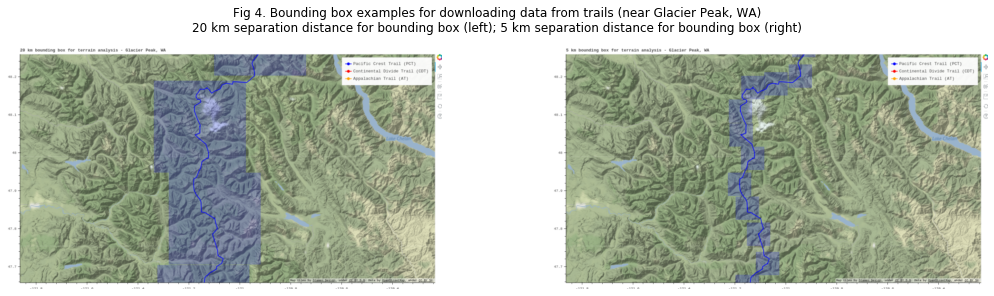

In [11]:
# Image added for report generation
img1 = mpimg.imread("./data/images/bounding-box-glacier-20k-map.png")
img2 = mpimg.imread("./data/images/bounding-box-glacier-5k-map.png")
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15,4))
axs[0].imshow(img1, interpolation="bilinear")
axs[1].imshow(img2, interpolation="bilinear")
axs[0].axis('off')
axs[1].axis('off')
fig.suptitle('Fig 4. Bounding box examples for downloading data from trails (near Glacier Peak, WA)\n20 km separation distance for bounding box (left); 5 km separation distance for bounding box (right)')
fig.show()

## Download and import terrain data from selected points

This step was made much easier by using the API provided by OpenTopology.com. If you have the coordinates for the extents of a bounding box to download, it is as simple as an API call to gather the DEM data. The main concern is to ensure that the calculations made for the bounding box are made in the correct coordinate system. A simplification was made to choose a consistent distance as degree for the bounding boxes, allowing the same size file for each DEM file at the expense of some loss in bounding box distance accuracy.

> Note: One important decision made at this point was to remove the average elevation from each DEM file, essentially removing the idea of which specific elevation the sample was taken from. This was done to ensure the analysis is not picking up only the elevation of where a data point is taken - it would be trivial to say if you are very high in elevation that you are likely to be in Colorado. However, we do not want to fully normalize the data, since a nearby higher mountain peak is relevant to the local terrain.

In [12]:
spacing=5000
pct = project.Trail()
pct.process_trail_from_shapefile('./data/trail-shapefiles/pct/', subsample_rate=100, spacing=spacing)

cdt = project.Trail()
cdt.process_trail_from_shapefile('./data/trail-shapefiles/cdt/', subsample_rate=1000, spacing=spacing)

at = project.Trail()
at.process_trail_from_shapefile('./data/trail-shapefiles/at/', subsample_rate=100, spacing=spacing)

# Make paths for for 5k dem files 
pct_dem_path = './data/dem/{}-{}/'.format('pct', spacing)
cdt_dem_path = './data/dem/{}-{}/'.format('cdt', spacing)
at_dem_path = './data/dem/{}-{}/'.format('at', spacing)

Path(pct_dem_path).mkdir(parents=True, exist_ok=True)
Path(cdt_dem_path).mkdir(parents=True, exist_ok=True)
Path(at_dem_path).mkdir(parents=True, exist_ok=True)

In [13]:
%%script false --no-raise-error
pct.download_coordinates(relative_directory=pct_dem_path)

In [14]:
%%script false --no-raise-error
cdt.download_coordinates(relative_directory=cdt_dem_path)

In [15]:
%%script false --no-raise-error
at.download_coordinates(relative_directory=at_dem_path)

In [16]:
spacing=20000
pct = project.Trail()
pct.process_trail_from_shapefile('./data/trail-shapefiles/pct/', subsample_rate=100, spacing=spacing)

cdt = project.Trail()
cdt.process_trail_from_shapefile('./data/trail-shapefiles/cdt/', subsample_rate=1000, spacing=spacing)

at = project.Trail()
at.process_trail_from_shapefile('./data/trail-shapefiles/at/', subsample_rate=100, spacing=spacing)

# Make paths for for 20k dem files 
pct_dem_path = './data/dem/{}-{}/'.format('pct', spacing)
cdt_dem_path = './data/dem/{}-{}/'.format('cdt', spacing)
at_dem_path = './data/dem/{}-{}/'.format('at', spacing)

Path(pct_dem_path).mkdir(parents=True, exist_ok=True)
Path(cdt_dem_path).mkdir(parents=True, exist_ok=True)
Path(at_dem_path).mkdir(parents=True, exist_ok=True)

In [17]:
%%script false --no-raise-error
pct.download_coordinates(relative_directory=pct_dem_path)

In [18]:
%%script false --no-raise-error
cdt.download_coordinates(relative_directory=cdt_dem_path)

In [19]:
%%script false --no-raise-error
at.download_coordinates(relative_directory=at_dem_path)

## Perform Continuous Wavelet Transform (CWT) to filter appropriate frequencies.

The Continuous Wavelet Transform (CWT) is used as a filtering method. It may be possible to build a targeted frequency based on the FFT spectrum, but it is has been much more efficient to perform the CWT and choose an appropriate level from the resulting coefficients as a filter.

We will review the CWT results of the Glacier Peak, WA for a mountainous region and a desert region in NM for a flat terrain sample to see how the filtering performs.

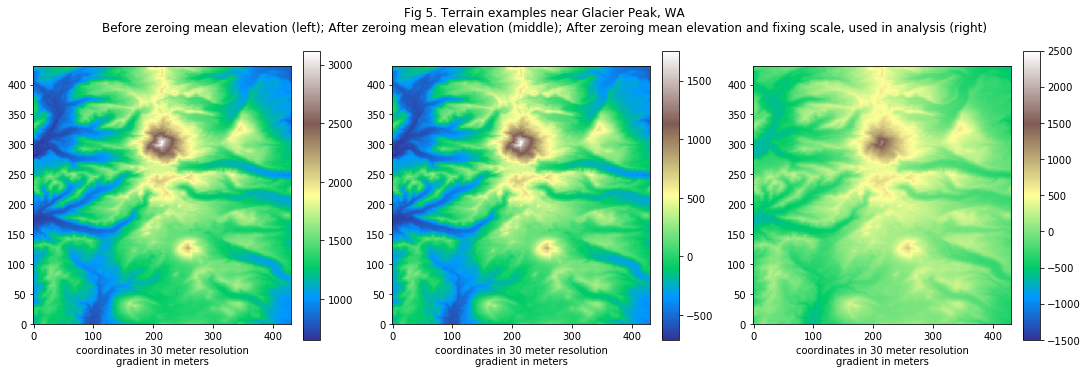

In [20]:
ter1 = project.Terrain()
ter1.load_dem_directory('./data/dem/pct-20000/')
ter1.X.min()

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15,5))
pos1 = axs[0].imshow(ter1.X[50].reshape(431,431), origin='lower', cmap='terrain')
ter1.subtract_mean_from_dem()
pos2 = axs[1].imshow(ter1.X[50].reshape(431,431), origin='lower', cmap='terrain')
pos3 = axs[2].imshow(ter1.X[50].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)

axs[0].set_xlabel('coordinates in 30 meter resolution\ngradient in meters')
axs[1].set_xlabel('coordinates in 30 meter resolution\ngradient in meters')
axs[2].set_xlabel('coordinates in 30 meter resolution\ngradient in meters')
fig.colorbar(pos1, ax=axs[0], aspect=50)
fig.colorbar(pos2, ax=axs[1], aspect=50)
fig.colorbar(pos3, ax=axs[2], aspect=50)

fig.suptitle('Fig 5. Terrain examples near Glacier Peak, WA\nBefore zeroing mean elevation (left); After zeroing mean elevation (middle); After zeroing mean elevation and fixing scale, used in analysis (right)')
fig.show()



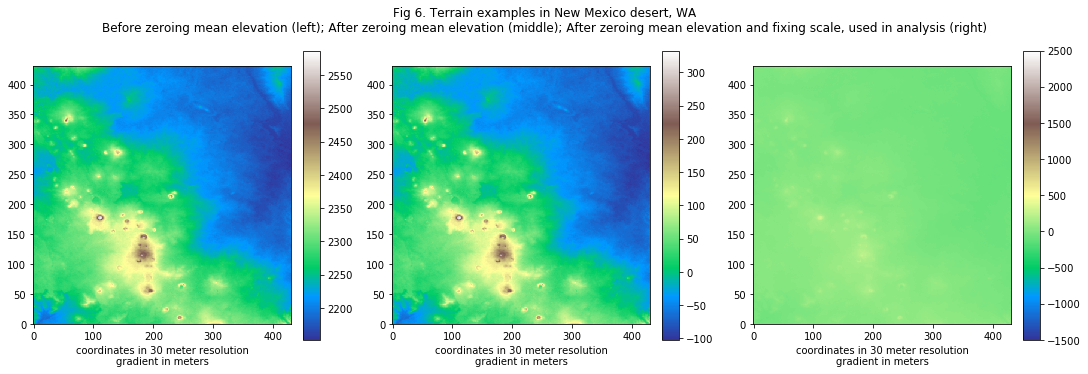

In [21]:
ter2 = project.Terrain()
ter2.load_dem_directory('./data/dem/cdt-20000/')

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15,5))
pos1 = axs[0].imshow(ter2.X[11].reshape(431,431), origin='lower', cmap='terrain')
ter2.subtract_mean_from_dem()
pos2 = axs[1].imshow(ter2.X[11].reshape(431,431), origin='lower', cmap='terrain')
pos3 = axs[2].imshow(ter2.X[11].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)

axs[0].set_xlabel('coordinates in 30 meter resolution\ngradient in meters')
axs[1].set_xlabel('coordinates in 30 meter resolution\ngradient in meters')
axs[2].set_xlabel('coordinates in 30 meter resolution\ngradient in meters')
fig.colorbar(pos1, ax=axs[0], aspect=50)
fig.colorbar(pos2, ax=axs[1], aspect=50)
fig.colorbar(pos3, ax=axs[2], aspect=50)

fig.suptitle('Fig 6. Terrain examples in New Mexico desert, WA\nBefore zeroing mean elevation (left); After zeroing mean elevation (middle); After zeroing mean elevation and fixing scale, used in analysis (right)')
fig.show()



### Selecting CWT component for filtering

Now that we have completed zeroing out the means, it looks like we have appropriate samples to review - a sample with a large variance and a sample with almost no variance. See Fig 6. for example CWT for filtering these samples.



In [22]:
ter1.get_cwt()

In [23]:
ter2.get_cwt()

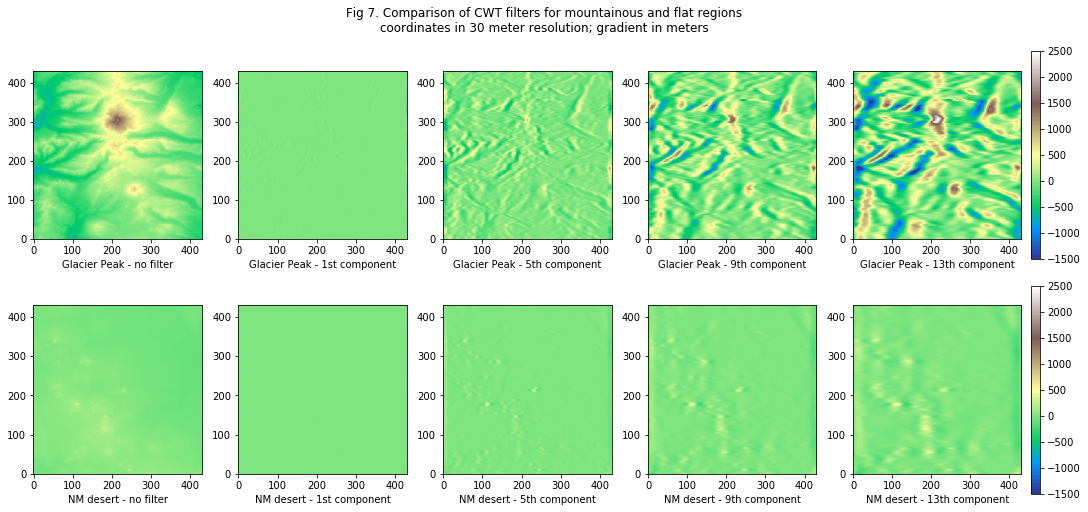

In [24]:
fig, axs = plt.subplots(2, 5, constrained_layout=True, figsize=(15,7))
pos00 = axs[0, 0].imshow(ter1.X[50].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
pos10 = axs[1, 0].imshow(ter2.X[11].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
pos00 = axs[0, 1].imshow(ter1.cA[0][50].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
pos10 = axs[1, 1].imshow(ter2.cA[0][11].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
pos00 = axs[0, 2].imshow(ter1.cA[4][50].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
pos10 = axs[1, 2].imshow(ter2.cA[4][11].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
pos00 = axs[0, 3].imshow(ter1.cA[8][50].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
pos10 = axs[1, 3].imshow(ter2.cA[8][11].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
pos00 = axs[0, 4].imshow(ter1.cA[12][50].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
pos10 = axs[1, 4].imshow(ter2.cA[12][11].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)

axs[0,0].set_xlabel('Glacier Peak - no filter')
axs[1,0].set_xlabel('NM desert - no filter')
axs[0,1].set_xlabel('Glacier Peak - 1st component')
axs[1,1].set_xlabel('NM desert - 1st component')
axs[0,2].set_xlabel('Glacier Peak - 5th component')
axs[1,2].set_xlabel('NM desert - 5th component')
axs[0,3].set_xlabel('Glacier Peak - 9th component')
axs[1,3].set_xlabel('NM desert - 9th component')
axs[0,4].set_xlabel('Glacier Peak - 13th component')
axs[1,4].set_xlabel('NM desert - 13th component')
fig.colorbar(pos00, ax=axs[0, 4], aspect=50)
fig.colorbar(pos10, ax=axs[1, 4], aspect=50)

fig.suptitle('Fig 7. Comparison of CWT filters for mountainous and flat regions\ncoordinates in 30 meter resolution; gradient in meters')
fig.show()

We will select the 5th component filter as it appears to gather the most detail to differentiate and locate the shape of Glacier Peak while also limiting features on the desert. This parameter can be tuned to vary the geographic features being prioritized. Also note that the number of components for the CWT is much lower than preferred due to hardware limitations. It would be interesting to perform this analysis again with double or triple the number of CWT components to see if there is any effect.

We will review the frequency components of these two regions before and after the CWT filtering.


## Perform Fast Fourier Transform (FFT) and collapse axes to generate frequency signatures

The Fast Fourier Transform (FFT) is used to remove any location information from the filtered terrain and focus only on the frequencies. It is assumed that a hiker on the trail will not be concerned with specifically which direction a terrain feature is located, since as the hiker moves the terrain will always be in a shifting relative location. While the CWT is great at picking out location, we want to remove that location information with the FFT.

We will review the FFT results of the filtered terrain from Glacier Peak, WA and a flat desert section in New Mexico.

After performing the FFT the large majority of the frequency spectrum approaches zero, and we must zoom in significantly on the frequency spectrum to see any useful results.

> Note: The FFT results are combined together based on an average of the max frequencies in the x-direction and the max frequencies in the y-direction. This allows a simpler metric to review as a frequency key with similar information as full array of all FFT data.

In [25]:
ter1.get_fft_before_filter()
ter2.get_fft_before_filter()


In [26]:
component=4
ter1.get_fft_after_filter(component=component)
ter2.get_fft_after_filter(component=component)

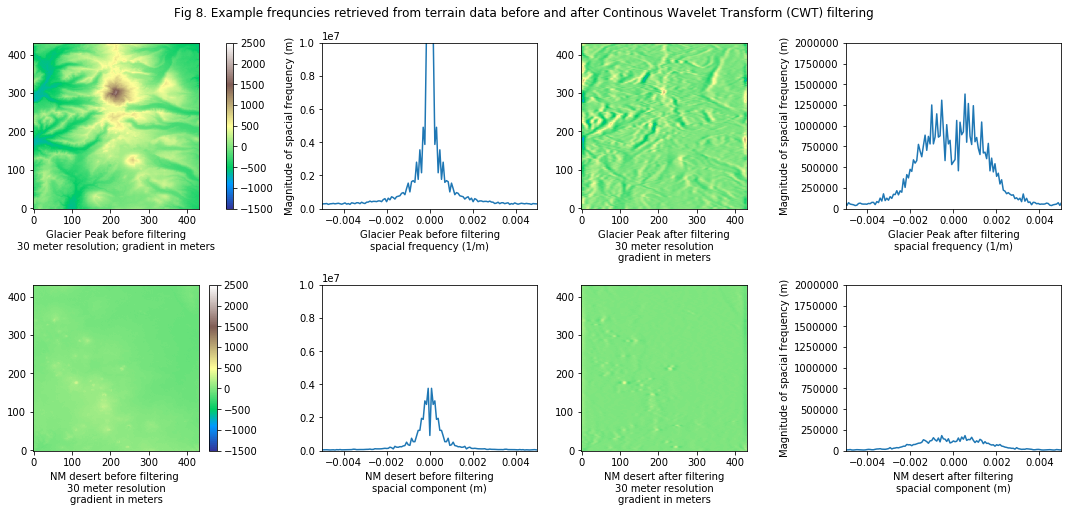

In [27]:
fig, axs = plt.subplots(2, 4, constrained_layout=True, figsize=(15,7))
pos00 = axs[0, 0].imshow(ter1.X[50].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
pos10 = axs[1, 0].imshow(ter2.X[11].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
axs[0,1].plot(ter1.fs, ter1.Xfs_comp[50])
axs[1,1].plot(ter2.fs, ter2.Xfs_comp[11])
pos02 = axs[0, 2].imshow(ter1.cA[component][50].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
pos12 = axs[1, 2].imshow(ter2.cA[component][11].reshape(431,431), origin='lower', cmap='terrain', vmin=-1500, vmax=2500)
axs[0,3].plot(ter1.fs, ter1.Cfs_comp[50])
axs[1,3].plot(ter2.fs, ter2.Cfs_comp[11])

axs[0,0].set_xlabel('Glacier Peak before filtering\n30 meter resolution; gradient in meters')
axs[1,0].set_xlabel('NM desert before filtering \n30 meter resolution\ngradient in meters')
axs[0,1].set_xlabel('Glacier Peak before filtering\nspacial frequency (1/m)')
axs[1,1].set_xlabel('NM desert before filtering\nspacial component (m)')
axs[0,2].set_xlabel('Glacier Peak after filtering\n30 meter resolution\ngradient in meters')
axs[1,2].set_xlabel('NM desert after filtering\n30 meter resolution\ngradient in meters')
axs[0,3].set_xlabel('Glacier Peak after filtering\nspacial frequency (1/m)')
axs[1,3].set_xlabel('NM desert after filtering\nspacial component (m)')

axs[0,1].set_ylabel('Magnitude of spacial frequency (m)')
axs[0,3].set_ylabel('Magnitude of spacial frequency (m)')
axs[1,3].set_ylabel('Magnitude of spacial frequency (m)')
axs[1,3].set_ylabel('Magnitude of spacial frequency (m)')



axs[0,1].set_xlim(-.005, 0.005)
axs[1,1].set_xlim(-.005, 0.005)
axs[0,1].set_ylim(0, 10e6)
axs[1,1].set_ylim(0, 10e6)

axs[0,3].set_xlim(-.005, 0.005)
axs[1,3].set_xlim(-.005, 0.005)
axs[0,3].set_ylim(0, 2e6)
axs[1,3].set_ylim(0, 2e6)

fig.colorbar(pos00, ax=axs[0, 0], aspect=50)
fig.colorbar(pos02, ax=axs[1, 0], aspect=50)
# fig.colorbar(pos3, ax=axs[2], aspect=50)

fig.suptitle('Fig 8. Example frequncies retrieved from terrain data before and after Continous Wavelet Transform (CWT) filtering')
fig.show()

## Review the frequency signatures with Singular Value Decomposition (SVD)

Finally, we pull together all of the terrain frequencies to locate which areas are the most unique in terms of the criteria selected in this analysis. Pulling out the "principal components" of the frequency data should be relatively straightforward. 

Note that because we are pushing frequencies through the SVD, and furthermore frequencies that lack any spacial component, visualizing the U and V matrices would be difficult. We will therefore focus on the S matrix, which highlights how complex the terrain is for the thru-hike trails in this analysis.


In [28]:
component=4

In [29]:
ter1 = project.Terrain()
ter1.load_dem_directory('./data/dem/pct-20000/')
ter1.subtract_mean_from_dem()

In [30]:
ter1.get_cwt()
ter1.get_fft_after_filter(component=component)

In [31]:
ter2 = project.Terrain()
ter2.load_dem_directory('./data/dem/cdt-20000/')
ter2.subtract_mean_from_dem()

In [32]:
ter2.get_cwt()
ter2.get_fft_after_filter(component=component)

In [33]:
ter3 = project.Terrain()
ter3.load_dem_directory('./data/dem/at-20000/')
ter3.subtract_mean_from_dem()

In [34]:
ter3.get_cwt()
ter3.get_fft_after_filter(component=component)

In [35]:
ter1.get_fft_before_filter()


In [36]:
# ter4 = project.Terrain()
# ter4.load_dem_directory('./data/dem/pct-5000/')
# ter4.subtract_mean_from_dem()


In [37]:
# ter4.get_cwt()
# ter4.get_fft_after_filter(component=component)

In [38]:
# ter4 = project.Terrain()
# ter4.load_dem_directory('./data/dem/pct-5000/')
# ter4.subtract_mean_from_dem()

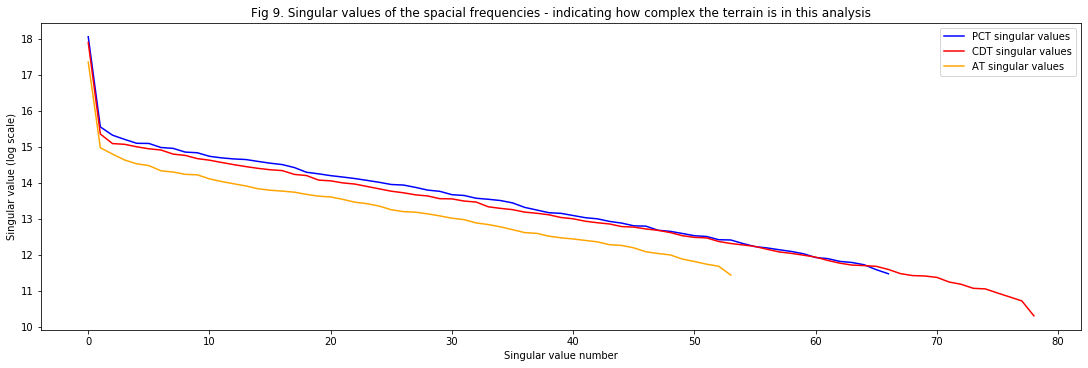

In [39]:
U1, S1, V1 = linalg.svd(ter1.Cfs_comp, full_matrices=False)
U2, S2, V2 = linalg.svd(ter2.Cfs_comp, full_matrices=False)
U3, S3, V3 = linalg.svd(ter3.Cfs_comp, full_matrices=False)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,5))

ax.plot(np.log(S1), label='PCT singular values', color='blue')
ax.plot(np.log(S2), label='CDT singular values', color='red')
ax.plot(np.log(S3), label='AT singular values', color='orange')

ax.set_title('Fig 9. Singular values of the spacial frequencies - indicating how complex the terrain is in this analysis')
ax.set_xlabel('Singular value number')
ax.set_ylabel('Singular value (log scale)')
ax.legend()
fig.show()

# Computational Results

The breakdown of the singular values shows the relative complexity between the trails is similar, as one would expect. It also shows that the terrain complexity does vary depending on the thru-hike chosen. As per Figure 9, the PCT is rated as more complex than the CDT, and both of those trials are much more complex than the AT (note that this is a log scale plot).

The end result is interesting - I assumed that either the PCT or CDT would be more complex than the AT, but I wasn't sure which would be rated more complex between the two. I look forward to reviewing the maps more to understand which areas of complexity are worth exploring.

Finally, the summary in Figure 10 is a resource to review which areas of the trail contribute to the complexity seen in the singular value analysis. Although much of this intuition could be found by reviewing a map, it is interesting to see the figures for comparison.

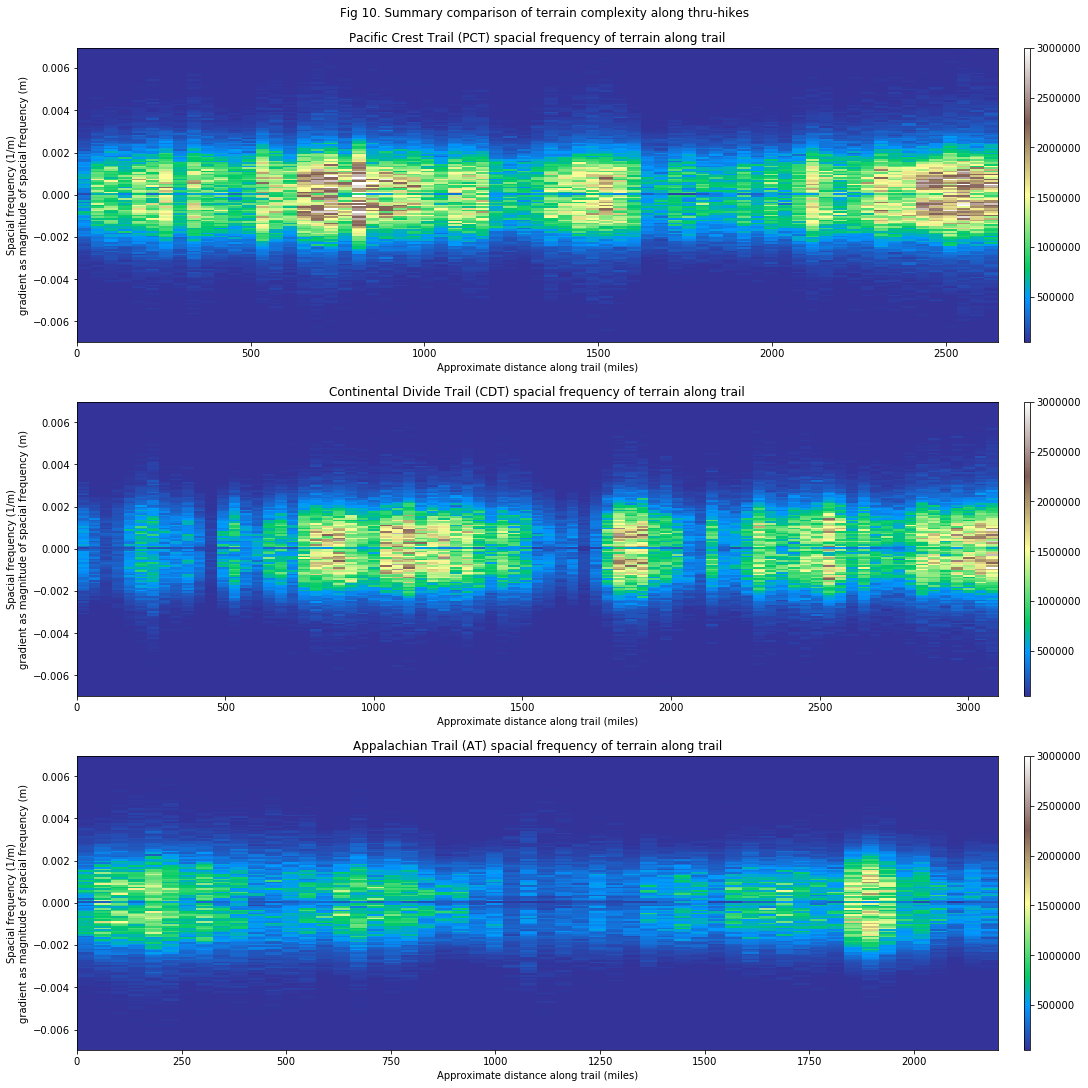

In [40]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(15,15))
vmin=50e3
vmax=3e6


data_mid = int(ter1.Cfs_comp.shape[1]/2)
data_filter = 90
pct_data = ter1.Cfs_comp[:,data_mid-data_filter:data_mid+data_filter]
cdt_data = ter2.Cfs_comp[:,data_mid-data_filter:data_mid+data_filter]
at_data = ter3.Cfs_comp[:,data_mid-data_filter:data_mid+data_filter]

fs_min = ter1.fs[data_mid-data_filter]
fs_max = ter1.fs[data_mid+data_filter]
pct_extent = [0,2650,fs_min,fs_max]
cdt_extent = [0,3100,fs_min,fs_max]
at_extent = [0,2200,fs_min,fs_max]
pos0 = axs[0].imshow(pct_data.T, aspect='auto', cmap='terrain', origin='lower', vmin=vmin, vmax=vmax, interpolation='none', extent=pct_extent)
pos1 = axs[1].imshow(cdt_data.T, aspect='auto', cmap='terrain', origin='lower', vmin=vmin, vmax=vmax, interpolation='none', extent=cdt_extent)
pos2 = axs[2].imshow(at_data.T, aspect='auto', cmap='terrain', origin='lower', vmin=vmin, vmax=vmax, interpolation='none', extent=at_extent)

axs[0].set_title('Pacific Crest Trail (PCT) spacial frequency of terrain along trail')
axs[1].set_title('Continental Divide Trail (CDT) spacial frequency of terrain along trail')
axs[2].set_title('Appalachian Trail (AT) spacial frequency of terrain along trail')

axs[0].set_xlabel('Approximate distance along trail (miles)')
axs[1].set_xlabel('Approximate distance along trail (miles)')
axs[2].set_xlabel('Approximate distance along trail (miles)')

axs[0].set_ylabel('Spacial frequency (1/m)\ngradient as magnitude of spacial frequency (m)')
axs[1].set_ylabel('Spacial frequency (1/m)\ngradient as magnitude of spacial frequency (m)')
axs[2].set_ylabel('Spacial frequency (1/m)\ngradient as magnitude of spacial frequency (m)')


fig.suptitle('Fig 10. Summary comparison of terrain complexity along thru-hikes')
fig.colorbar(pos0, ax=axs[0], aspect=50)
fig.colorbar(pos1, ax=axs[1], aspect=50)
fig.colorbar(pos2, ax=axs[2], aspect=50)

fig.savefig('./data/images/summary-figure.png')
fig.show()

# Summary and Conclusions

This has been a very interesting dive into geographic data. It is always said that 90% of the work in an analysis is getting the data formatted, and that is especially true when working with this kind of dataset. Although locating data and dealing with the coordinate transforms between geodesic and projected datasets was a large challenge, it was satisfying to start analyzing the data once it was collected.

One challenge with working with terrain data is how inherently correlated and connected each section of terrain is. It is an interesting challenge to try to find complexity in terrain based only on elevation data, when similar information could be found by checking other features like local weather trends, local vegetation cover, distance from a fault lines, and types of local ecosystems. In some sense working with only elevation data makes for a good analysis challenge but it is hard to say how useful it is when removed from other important data sources.

One thing this analysis has been able to show definitely is that transforms, such as CWT, FFT, and SVD are very useful in a variety of contexts. I was surprised how quickly an analysis of elevation terrain data began to resemble an analysis of images or video. These tools are able to process a very large amount of data quickly, and were able to reduce the complexity of a terrain analysis problem immensely.

And, if we all agree to rate a trail based on the terrain complexity as described within this very specific analysis, than we can say definitively we can all agree that the PCT is clearly the best thru-hike in the United States.

# Appendix A (python packages) {-}

package | function | description
--- | --- | ---
**numpy**  | `numpy.fft` | used for matrix operations including FFT
**scipy** | `linalg.svd` | used to perform SVD calculations, returns USV from matrix M
**matplotlib** | `matplotlib.pyplot` | used for plotting
**pathlib** | `pathlib.Path` | used to walk through folder structure to gather images
**osgeo** | `osgeo.gdal` | used for import and processing of DEM files
**pyproj** | `pyproj.transform` | used to transform between geometric projections
**geopandas** | `geopandas` | used to import and manipulate shapefiles
**pywt** | `pywt.cwt` | used for CWT edge filtering
**sklearn** | `sklearn.svm.SVC` | used as simple classifier
**bokeh** | `bokeh` | used for interactive visualizations


# Appendix B (python code) {-}

#### Github code {-}

https://github.com/micahg0/thru-hike-terrain-analysis/

See github for full code, the Jupyter notebook used to generate this report, and environment
requirements to repeat this analysis.


In [41]:
with open('./project.py') as f:
    print(f.read())

import numpy as np
import logging
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.linalg import svd
from scipy.io import wavfile
from scipy import signal
from scipy.spatial.distance import pdist, squareform
import itertools
from pyproj import Proj, transform, Transformer
from pathlib import Path
import pywt
import subprocess
import os
import requests
from osgeo import gdal

import geopandas as gpd
import shapely
import geopy



logger = logging.getLogger()


class Trail:
    """ Class for working with data along trail, including shapefiles, Digital Elevation Model (DEM) files, and downloading from OpenTopography.com API"""

    def __init__(self):
        self.shapefile_directory = None
        self.df = None
        self.coordinates = None
        self.file_path = None
        self.idx_start = None
        self.idx_stop = None
        self.coordinates_sampled = None
        self.bounding_box_set = None
        self.bounding_box_centers = None
        return
    
  

In [42]:
# Script to save notebook, pause to make sure save is complete, copy to temp file, and export temp file to pdf for viewing.
from IPython.display import display, Javascript
import time
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(5)
! cp 'Thru-Hike-Terrain-Analysis.ipynb' .temp-output.ipynb
!jupyter nbconvert --to=pdf  --output "Thru-hike terrain analysis - Is the PCT, CDT, or AT better" .temp-output.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags="['remove_cell']"  --no-prompt --no-input

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook .temp-output.ipynb to pdf
/opt/conda/lib/python3.7/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  mimetypes=output.keys())
/opt/conda/lib/python3.7/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/javascript', 'application/vnd.bokehjs_load.v0+json']) is not able to be represented.
  mimetypes=output.keys())
/opt/conda/lib/python3.7/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/javascript', 'application/vnd.bokehjs_exec.v0+json']) is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Support files will be in Thru-hike terrain analysis - Is the PCT, CDT, or AT better_files/
[NbConvertApp] Making directory ./Thru-hike terrain analysis - Is the PCT, CDT, or AT better_files
[NbConvertApp